In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, GRU, SimpleRNN
from keras.layers import Dropout, LayerNormalization
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

## EDA

In [2]:
data = pd.read_csv("train.csv")
print(data.head())
print("Data shape:", data.shape)
print("Missing values:", data.isnull().sum())

print(data.describe())

                                              Quotes
0  Embrace the beauty of every sunrise; it's a fr...
1  Embrace challenges; they are the stepping ston...
2  Embrace the rhythm of life and let it dance th...
3  Embrace kindness, for it has the power to chan...
4  Embrace the journey, for it leads to the desti...
Data shape: (1000, 1)
Missing values: Quotes    0
dtype: int64
                                                   Quotes
count                                                1000
unique                                                890
top     Radiate acceptance, and find peace in embracin...
freq                                                    5


In [3]:
data = data.drop_duplicates()
data = list(data['Quotes'])

In [4]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(data)
tokenizer.word_index

{'the': 1,
 'of': 2,
 'your': 3,
 'and': 4,
 'a': 5,
 'is': 6,
 'in': 7,
 'for': 8,
 'let': 9,
 'to': 10,
 'it': 11,
 'be': 12,
 'every': 13,
 'our': 14,
 'you': 15,
 'that': 16,
 'embrace': 17,
 "life's": 18,
 'this': 19,
 'are': 20,
 'morning': 21,
 'with': 22,
 'radiate': 23,
 'dance': 24,
 'heart': 25,
 'believe': 26,
 'yourself': 27,
 'through': 28,
 "planet's": 29,
 'will': 30,
 'life': 31,
 'love': 32,
 'they': 33,
 "singapore's": 34,
 'kindness': 35,
 'power': 36,
 'from': 37,
 'dreams': 38,
 'we': 39,
 'soul': 40,
 'symphony': 41,
 'act': 42,
 'find': 43,
 'gratitude': 44,
 'singapore': 45,
 'world': 46,
 'strength': 47,
 'light': 48,
 'beauty': 49,
 'journey': 50,
 'nature': 51,
 'joy': 52,
 'planet': 53,
 'canvas': 54,
 'colors': 55,
 'way': 56,
 'whispers': 57,
 'where': 58,
 'potential': 59,
 'hope': 60,
 'testament': 61,
 'resilience': 62,
 'towards': 63,
 'true': 64,
 'new': 65,
 'compassion': 66,
 'beacon': 67,
 'actions': 68,
 'future': 69,
 'spirit': 70,
 'step': 71,


In [5]:
print(data[0])
print(tokenizer.texts_to_sequences([data[1]]))

Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
[[17, 148, 33, 20, 1, 373, 487, 10, 3, 374, 687]]


In [6]:
sequences = tokenizer.texts_to_sequences(data)
padded_sequences = pad_sequences(sequences, padding="pre")

In [7]:
print(len(padded_sequences[0]))

35


In [8]:
word_freq = tokenizer.word_counts
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq[:10])

num_unique_words = len(tokenizer.word_index)
print(f"There are {num_unique_words} unique words.")

[('the', 869), ('of', 663), ('your', 350), ('and', 322), ('a', 307), ('is', 253), ('in', 249), ('for', 201), ('let', 187), ('to', 180)]
There are 1198 unique words.


There's 890 Quotes and 1198 Unique Words. In those 890 quotes we have 869 'the' and 663 'of' it's very likely that the model we build will often predict those 2 phrases very often.

### How to deal with 'the' and 'of'
We can create new data, that is less biased towards the 'the' and 'of'.  
Slice the quotes into different sizes and then train the model on that

In [9]:
# Split the data into 2, 3 words
phrases = []
for quote in sequences:
    for phrase_length in range(2, 8):  
        for i in range(len(quote) - phrase_length + 1):
            phrases.append(quote[i : i + phrase_length])  

total_data = phrases + sequences
max_sequence_len = max([len(x) for x in total_data])
padded_sequences = pad_sequences(total_data, maxlen=max_sequence_len, padding="pre")

In [10]:
x = padded_sequences[:, :-1]
labels = padded_sequences[:, -1]
labels_encoded = tf.keras.utils.to_categorical(labels, num_classes=num_unique_words + 1)

print(x.shape)
print(labels_encoded.shape)
vocab_size = len(tokenizer.word_index) + 1

(45914, 34)
(45914, 1199)


### Train the inital model

In [13]:
def first_model_LSTM():
    model = Sequential()

    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))
    model.add(LSTM(256))
    model.add(Dropout(0.2))

    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model

def first_model_GRU():
    model = Sequential()

    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))
    model.add(GRU(256, return_sequences=False))
    model.add(Dropout(0.2))


    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model

def basic_rnn_model():
    model = Sequential()

    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))
    model.add(SimpleRNN(256))
    model.add(Dropout(0.2))

    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model

basic_rnn = basic_rnn_model()
base_LSTM = first_model_LSTM()
base_GRU = first_model_GRU()


history_basic_rnn_model = basic_rnn.fit(x, labels_encoded, batch_size=128,epochs=100,verbose=1,shuffle=True,
    callbacks=[EarlyStopping(monitor="loss", patience=3),
        ModelCheckpoint(filepath="base_model_rnn.h5", monitor="loss", save_best_only=True),
    ],
)

history_base_LSTM = first_model_LSTM().fit(x, labels_encoded, batch_size=128, epochs=100, verbose=1, shuffle=True,
    callbacks=[EarlyStopping(monitor="loss", patience=3),
        ModelCheckpoint(filepath="base_model_LSTM.h5", monitor="loss", save_best_only=True),
    ],
)

history_base_GRU = base_GRU.fit(x, labels_encoded, batch_size=128, epochs=100, verbose=1, shuffle=True,
    callbacks=[EarlyStopping(monitor="loss", patience=3),
        ModelCheckpoint(filepath="base_model_GRU.h5", monitor="loss", save_best_only=True),
    ],
)


Epoch 1/100
359/359 [==============================] - 12s 32ms/step - loss: 5.2299 - accuracy: 0.1283
Epoch 2/100
359/359 [==============================] - 11s 31ms/step - loss: 3.9796 - accuracy: 0.2503
Epoch 3/100
359/359 [==============================] - 11s 31ms/step - loss: 3.2911 - accuracy: 0.3289
Epoch 4/100
359/359 [==============================] - 11s 32ms/step - loss: 2.8366 - accuracy: 0.3888
Epoch 5/100
359/359 [==============================] - 11s 31ms/step - loss: 2.5077 - accuracy: 0.4396
Epoch 6/100
359/359 [==============================] - 11s 30ms/step - loss: 2.2621 - accuracy: 0.4844
Epoch 7/100
359/359 [==============================] - 11s 31ms/step - loss: 2.0755 - accuracy: 0.5184
Epoch 8/100
359/359 [==============================] - 11s 31ms/step - loss: 1.9337 - accuracy: 0.5412
Epoch 9/100
359/359 [==============================] - 11s 31ms/step - loss: 1.8188 - accuracy: 0.5634
Epoch 10/100
359/359 [==============================] - 11s 32ms/step - l

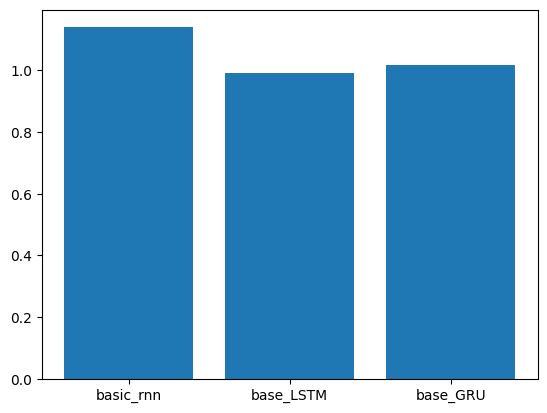

In [15]:
results_base = pd.DataFrame(
    [{
        "basic_rnn": min(history_basic_rnn_model.history["loss"]),
        "base_LSTM": min(history_base_LSTM.history["loss"]),
        "base_GRU": min(history_base_GRU.history["loss"]),
    }]
)
plt.bar(results_base.columns, results_base.iloc[0])
plt.show()

In [22]:
def tune_model_layers(number_layers):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))
    if number_layers != 0:
        for i in range(number_layers):
            model.add(LSTM(256, return_sequences=True))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))


    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    
    history = model.fit(
        x,
        labels_encoded,
        batch_size=64,
        epochs=100,
        verbose=1,
        shuffle=True,
    )
    return history

Epoch 1/100
718/718 [==============================] - 6s 7ms/step - loss: 5.2025 - accuracy: 0.1099
Epoch 2/100
718/718 [==============================] - 5s 7ms/step - loss: 4.4856 - accuracy: 0.1642
Epoch 3/100
718/718 [==============================] - 5s 7ms/step - loss: 3.8169 - accuracy: 0.2593
Epoch 4/100
718/718 [==============================] - 5s 7ms/step - loss: 3.2557 - accuracy: 0.3364
Epoch 5/100
718/718 [==============================] - 7s 10ms/step - loss: 2.8887 - accuracy: 0.3802
Epoch 6/100
718/718 [==============================] - 5s 7ms/step - loss: 2.6179 - accuracy: 0.4165
Epoch 7/100
718/718 [==============================] - 5s 7ms/step - loss: 2.4243 - accuracy: 0.4484
Epoch 8/100
718/718 [==============================] - 5s 7ms/step - loss: 2.2433 - accuracy: 0.4768
Epoch 9/100
718/718 [==============================] - 5s 7ms/step - loss: 2.1010 - accuracy: 0.5018
Epoch 10/100
718/718 [==============================] - 5s 7ms/step - loss: 1.9832 - accur

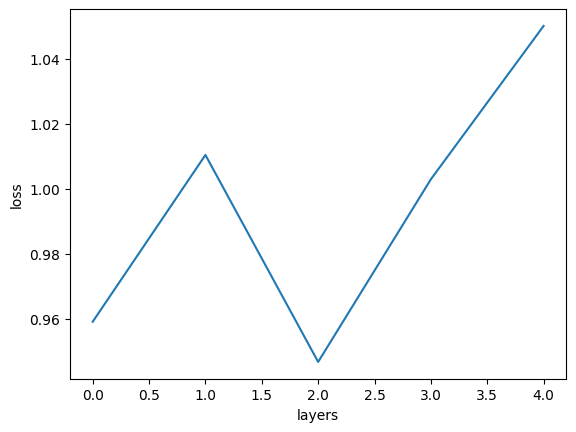

In [23]:
results = []
for i in range(0, 5):
    history_layers = tune_model_layers(i)
    results.append({
            "layers": i,
            "loss": min(history_layers.history["loss"]),
            "accuracy": max(history_layers.history["accuracy"]),
        })
    
results_layers = pd.DataFrame(results)
sns.lineplot(x="layers", y="loss", data=results_layers)
plt.show()

In [25]:
def tune_model_LSTM(lstm_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))

    for i in range(2):
        model.add(LSTM(lstm_size, return_sequences=True))
        model.add(LayerNormalization())
        model.add(Dropout(0.2))


    model.add(LSTM(lstm_size))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    
    history = model.fit(
        x,
        labels_encoded,
        batch_size=64,
        epochs=100,
        verbose=1,
        shuffle=True,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="loss", patience=10, min_delta=0.0001, restore_best_weights=True
            )
        ],
    )
    return history

In [26]:
results = []
lstm_sizes = [32, 64, 128, 256, 512]
for i in lstm_sizes:
    history_layers = tune_model_LSTM(i)
    results.append({
            "units": i,
            "loss": min(history_layers.history["loss"]),
            "accuracy": max(history_layers.history["accuracy"]),
        })
results_units = pd.DataFrame(results)

Epoch 1/100
718/718 [==============================] - 13s 14ms/step - loss: 5.4908 - accuracy: 0.0796
Epoch 2/100
718/718 [==============================] - 10s 14ms/step - loss: 5.0120 - accuracy: 0.0992
Epoch 3/100
718/718 [==============================] - 10s 14ms/step - loss: 4.7394 - accuracy: 0.1314
Epoch 4/100
718/718 [==============================] - 10s 13ms/step - loss: 4.4949 - accuracy: 0.1631
Epoch 5/100
718/718 [==============================] - 9s 13ms/step - loss: 4.2709 - accuracy: 0.2031
Epoch 6/100
718/718 [==============================] - 9s 13ms/step - loss: 4.0637 - accuracy: 0.2319
Epoch 7/100
718/718 [==============================] - 9s 13ms/step - loss: 3.8879 - accuracy: 0.2525
Epoch 8/100
718/718 [==============================] - 9s 13ms/step - loss: 3.7611 - accuracy: 0.2641
Epoch 9/100
718/718 [==============================] - 9s 13ms/step - loss: 3.6434 - accuracy: 0.2766
Epoch 10/100
718/718 [==============================] - 9s 13ms/step - loss: 3

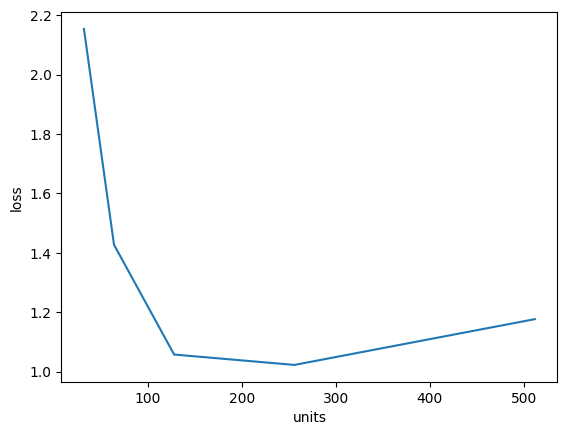

In [27]:
sns.lineplot(x='units', y="loss", data=results_units)
plt.show()

In [28]:
results_units

,units,loss,accuracy
0,32,2.153675,0.487999
1,64,1.426981,0.622512
2,128,1.057209,0.699395
3,256,1.022263,0.703750
4,512,1.176413,0.665091


In [43]:
def final_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))
    for i in range(2):
        model.add(LSTM(256, return_sequences=True))
        model.add(LayerNormalization())
        model.add(Dropout(0.2))

    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [37]:
final_model = final_model()
final_model.fit(
    x,
    labels_encoded,
    batch_size=64,
    epochs=100,
    verbose=1,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor="loss", patience=10, min_delta=0.0001, restore_best_weights=True),
        ModelCheckpoint("rnn_final_model.h5", monitor="loss", save_best_only=True, verbose=1)
    ]
)

Epoch 1/100
717/718 [============================>.] - ETA: 0s - loss: 5.5033 - accuracy: 0.0788
Epoch 1: loss improved from inf to 5.50303, saving model to rnn_final_model.h5
718/718 [==============================] - 16s 18ms/step - loss: 5.5030 - accuracy: 0.0788
Epoch 2/100
717/718 [============================>.] - ETA: 0s - loss: 5.0671 - accuracy: 0.1165
Epoch 2: loss improved from 5.50303 to 5.06666, saving model to rnn_final_model.h5
718/718 [==============================] - 12s 17ms/step - loss: 5.0667 - accuracy: 0.1165
Epoch 3/100
715/718 [============================>.] - ETA: 0s - loss: 3.7472 - accuracy: 0.2742
Epoch 3: loss improved from 5.06666 to 3.74549, saving model to rnn_final_model.h5
718/718 [==============================] - 12s 16ms/step - loss: 3.7455 - accuracy: 0.2746
Epoch 4/100
718/718 [==============================] - ETA: 0s - loss: 3.0388 - accuracy: 0.3602
Epoch 4: loss improved from 3.74549 to 3.03883, saving model to rnn_final_model.h5
718/718 [==

In [38]:
def predict_next_N_words_unique(seed_texts, top_p=1, N_words=10):
    generated_texts = []
    for seed_text in seed_texts:
        current_generated_text = seed_text
        for i in range(N_words):
            seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
            padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
                [seed_sequence], maxlen=max_sequence_len - 1
            )
            predictions = final_model.predict(padded_sequence, verbose=0)[0]

            sorted_indices = np.argsort(predictions)[::-1]
            cumulative_probs = np.cumsum(predictions[sorted_indices])
            selected_indices = sorted_indices[cumulative_probs <= top_p]

            selected_probs = predictions[selected_indices] / np.sum(
                predictions[selected_indices]
            )

            next_index = np.random.choice(selected_indices, p=selected_probs)
            next_word = tokenizer.index_word[next_index]

            if (
                next_word is None
                or next_word == "end_token"
                or len(current_generated_text.split()) >= N_words + len(seed_text)
            ):
                break

            current_generated_text += " " + next_word
            seed_text += " " + next_word

        generated_texts.append(current_generated_text)
    return generated_texts

In [39]:
seed_texts = [
    "embrace each day",
    "radiate some",
    "believe that",
    "life's actual purpose is",
    "dance through each and every",
    "let your time and energy",
    "every person is",
    "our country Singapore is",
    "planet earth is",
    "morning and evening would make it",
]

In [40]:
predicted_texts = predict_next_N_words_unique(seed_texts)
for text in predicted_texts:
    print(text)


embrace each day with a heart full of gratitude for it will lift
radiate some authenticity for it is the essence of true beauty resides
believe that truly exists and let it light up the lives of
life's actual purpose is a tapestry woven with threads of love and laughter for
dance through each and every heart you touch the soul from its burdens intertwine creating
let your time and energy to chase your dreams and aspirations and dreams take flight
every person is a tribute to the boundless power of the heart to
our country Singapore is a pledge to tread lightly on our planet offers of
planet earth is a reminder of the gift of life on our planet
morning and evening would make it ignites the world around you towards joy and contentment reside


### Load in .h5 file 

In [ ]:
def final_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_sequence_len - 1))
    for i in range(2):
        model.add(LSTM(256, return_sequences=True))
        model.add(LayerNormalization())
        model.add(Dropout(0.2))

    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [44]:
final_model = final_model()
final_model.load_weights("rnn_final_model.h5")

In [45]:
def predict_next_N_words_unique(seed_texts, top_p=1, N_words=10):
    generated_texts = []
    for seed_text in seed_texts:
        current_generated_text = seed_text
        for i in range(N_words):
            seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
            padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
                [seed_sequence], maxlen=max_sequence_len - 1
            )
            predictions = final_model.predict(padded_sequence, verbose=0)[0]

            sorted_indices = np.argsort(predictions)[::-1]
            cumulative_probs = np.cumsum(predictions[sorted_indices])
            selected_indices = sorted_indices[cumulative_probs <= top_p]

            selected_probs = predictions[selected_indices] / np.sum(
                predictions[selected_indices]
            )

            next_index = np.random.choice(selected_indices, p=selected_probs)
            next_word = tokenizer.index_word[next_index]

            if (
                next_word is None
                or next_word == "end_token"
                or len(current_generated_text.split()) >= N_words + len(seed_text)
            ):
                break

            current_generated_text += " " + next_word
            seed_text += " " + next_word

        generated_texts.append(current_generated_text)
    return generated_texts

In [46]:
predicted_texts = predict_next_N_words_unique(seed_texts)
for text in predicted_texts:
    print(text)

embrace each day with a heart full of gratitude for it will lift
radiate some confidence and let it be the beacon that brightens the
believe that truly exists and you will conquer any challenge brings new
life's actual purpose is a testament to the beauty of our uniqueness and love
dance through each and every breath let gratitude fill your lungs and heart this morning
let your time and energy to chase your dreams and aspirations and actions be the
every person is a testament to our commitment to our planet's future of
our country Singapore is a pledge to tread lightly on our planet offers of
planet earth is a step towards miracles the extraordinary moments that defy logic
morning and evening would make it spreads like wildfire to sparks change and wisdom and love
